In [1]:
%cd ~/repo/protein-transfer

/home/t-fli/repo/protein-transfer


In [2]:
%load_ext blackcellmagic

In [3]:
import torch

# Load ESM-1b model
original_model, alphabet = torch.hub.load(
            "facebookresearch/esm:main", model="esm1_t6_43M_UR50S"
        )
batch_converter = alphabet.get_batch_converter()
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG")
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

original_model.eval()
with torch.no_grad():
    original_results = original_model(batch_tokens, repr_layers=[6], return_contacts=False)
original_reps = original_results["representations"][6].numpy().mean(axis=1).flatten()

Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main


In [4]:
from torch.nn.init import xavier_uniform_, xavier_normal_

In [5]:
from scr.params.sys import DEVICE

In [7]:
import copy

def reset_parameters(model):
    """Initiate parameters in the transformer model."""

    for p in model.parameters():
        if p.dim() > 1:
            xavier_uniform_(p)
    
    return model

def resample_parameters(model):

    for p in model.parameters():
        if p.dim() > 1:
            xavier_normal_(p)
    
    return model

In [11]:
import matplotlib.pyplot as plt

In [8]:
model = copy.deepcopy(original_model).to(DEVICE)
model = reset_parameters(model)
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=False)
reset_reps = results["representations"][6].numpy().mean(axis=1).flatten()

In [9]:
model = copy.deepcopy(original_model).to(DEVICE)
model = resample_parameters(model)
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=False)
resample_reps = results["representations"][6].numpy().mean(axis=1).flatten()

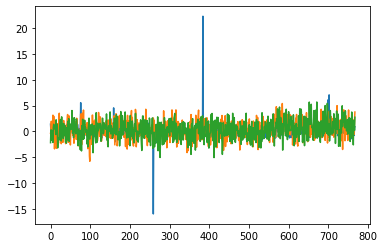

In [12]:
plt.plot(original_reps)
plt.plot(reset_reps)
plt.plot(resample_reps)

In [13]:
from sequence_models.pretrained import load_model_and_alphabet

original_model, collater = load_model_and_alphabet('carp_600k')

seqs = [['MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG']]
x = collater(seqs)[0]  # (n, max_len)
original_rep = original_model(x).detach().numpy().mean(axis=1)  # (n, max_len, d_model)
original_rep.shape

(1, 128)

In [14]:
import copy

In [15]:
model = copy.deepcopy(original_model).to(DEVICE)
model = reset_parameters(model)
model.eval()  # disables dropout for deterministic results

reset_reps = model(x).detach().numpy().mean(axis=1)
reset_reps.shape

(1, 128)

In [16]:
model = copy.deepcopy(original_model).to(DEVICE)
model = resample_parameters(model)
model.eval()  # disables dropout for deterministic results

resample_reps = model(x).detach().numpy().mean(axis=1)
resample_reps.shape

(1, 128)

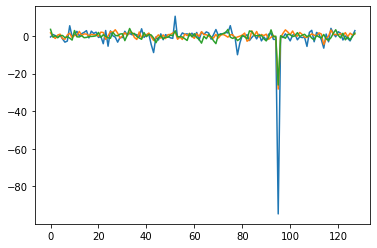

In [17]:
plt.plot(original_rep.T)
plt.plot(reset_reps.T)
plt.plot(resample_reps.T)